In [6]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tanuj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [245]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [246]:
# seeding
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [247]:
df = pd.read_csv("sqli.csv", encoding='utf-16')

In [248]:
df.head()

,Sentence,Label
0,select * from users where id = 1 or ( \ ) =...,1
1,select * from users where id = 1 or ( \. ) ...,1
2,select * from users where id = 1 or ( \+ ) ...,1
3,select * from users where id = 1 or ( 1 ) =...,1
4,select * from users where id = 1 or ( \+ ) ...,1


In [249]:
df.isnull().sum()

Sentence    379
Label         0
dtype: int64

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5437 entries, 0 to 5436
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  5058 non-null   object
 1   Label     5437 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 85.1+ KB


In [251]:
df = df.dropna()

In [252]:
texts = df['Sentence'].astype(str).tolist()
labels = df['Label'].tolist()

# Tokenization and vocabulary

In [253]:
# Tokenization
def tokenize(text):
    return word_tokenize(text.lower())

# vocabulary
word_freq = {}
for text in texts:
    for word in tokenize(text):
        word_freq[word] = word_freq.get(word, 0) + 1

In [254]:
# word-to-index mapping
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_freq.items())}
vocab['<pad>'] = 0
vocab['<unk>'] = 1
pad_idx = vocab['<pad>']
unk_idx = vocab['<unk>']
vocab_size = len(vocab)

# Padding

In [255]:
# pad sequences
def encode_and_pad(text, vocab, tokenizer, max_len):
    tokens = tokenizer(text)
    ids = [vocab.get(token, unk_idx) for token in tokens]
    if len(ids) < max_len:
        ids = ids + [pad_idx] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

In [256]:
lengths = [len(tokenize(text)) for text in texts]
max_len = int(np.percentile(lengths, 95))

encoded = [encode_and_pad(t, vocab, tokenize, max_len) for t in texts]

# Train test split

In [257]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    encoded, labels,
    test_size=0.3,
    stratify=labels,
    random_state=42,
    shuffle=True
)

# Dataset (pytorch)

In [258]:
torch_labels_train = torch.tensor(y_train, dtype=torch.float)
torch_labels_test = torch.tensor(y_test, dtype=torch.float)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = self.labels[idx]
        return text, label

train_dataset = TextDataset(X_train, torch_labels_train)
test_dataset = TextDataset(X_test, torch_labels_test)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#  LSTM model

In [259]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim=1, dropout=0.5, padding_idx=0):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim , output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_out = lstm_out[:, -1, :]
        out = self.dropout(last_out)
        logits = self.fc(out).squeeze(1)
        return logits

# Training 

In [260]:
# Hyperparameters
embed_dim = 100
hidden_dim = 64
num_epochs = 50
learning_rate = 0.0001

# Early stopping settings
patience = 2    # how many epochs to wait after last time validation loss improved
best_val_loss = float('inf')
epochs_no_improve = 0

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, padding_idx=pad_idx).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

train_losses = []
val_losses   = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    train_preds, train_labels  = [], []

    for texts_batch, labels_batch in train_loader:
        texts_batch = texts_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(texts_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        preds = torch.sigmoid(outputs).round().cpu().detach().numpy()
        train_preds.extend(preds)
        train_labels.extend(labels_batch.cpu().numpy())
        
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_acc = accuracy_score(train_labels, train_preds)
    print(
    f"Epoch {epoch}/{num_epochs} – "
    f"Train Loss: {avg_train_loss:.4f}, "
    f"Train Acc: {train_acc:.4f}"
    )
    
    #evaluation
    model.eval()
    running_val_loss = 0.0
    val_preds, val_labels  = [], []
    with torch.no_grad():
        for texts_batch, labels_batch in test_loader:
            texts_batch = texts_batch.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(texts_batch)
            loss    = criterion(outputs, labels_batch)
            running_val_loss += loss.item()

            preds = torch.sigmoid(outputs).round().cpu().numpy()
            val_preds.extend(preds)
            val_labels .extend(labels_batch.cpu().numpy())

        avg_val_loss = running_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
    # ——— Early stopping check ———
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Optional: save the best model weights
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement in val loss for {patience} epochs. Stopping early.")
            break


Epoch 0/50 – Train Loss: 0.6976, Train Acc: 0.4277
Epoch 1/50 – Train Loss: 0.6399, Train Acc: 0.7469
Epoch 2/50 – Train Loss: 0.5169, Train Acc: 0.7556
Epoch 3/50 – Train Loss: 0.4491, Train Acc: 0.7966
Epoch 4/50 – Train Loss: 0.3103, Train Acc: 0.8946
Epoch 5/50 – Train Loss: 0.2175, Train Acc: 0.9562
Epoch 6/50 – Train Loss: 0.1821, Train Acc: 0.9644
Epoch 7/50 – Train Loss: 0.1578, Train Acc: 0.9695
Epoch 8/50 – Train Loss: 0.1485, Train Acc: 0.9712
Epoch 9/50 – Train Loss: 0.1351, Train Acc: 0.9734
Epoch 10/50 – Train Loss: 0.1323, Train Acc: 0.9740
Epoch 11/50 – Train Loss: 0.1294, Train Acc: 0.9743
Epoch 12/50 – Train Loss: 0.1254, Train Acc: 0.9751
Epoch 13/50 – Train Loss: 0.1234, Train Acc: 0.9751
Epoch 14/50 – Train Loss: 0.1185, Train Acc: 0.9757
Epoch 15/50 – Train Loss: 0.1194, Train Acc: 0.9754
Epoch 16/50 – Train Loss: 0.1151, Train Acc: 0.9763
No improvement in val loss for 2 epochs. Stopping early.


In [261]:
print(f"Test Accuracy: {accuracy_score(val_labels, val_preds):.4f}")
print("Classification Report:")
print(classification_report(val_labels, val_preds))
print("Confusion Matrix:")
print(confusion_matrix(val_labels, val_preds))


Test Accuracy: 0.9671
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1143
         1.0       0.96      0.90      0.93       375

    accuracy                           0.97      1518
   macro avg       0.97      0.94      0.95      1518
weighted avg       0.97      0.97      0.97      1518

Confusion Matrix:
[[1130   13]
 [  37  338]]


# Training accuracy

In [262]:
model.eval()
train_preds, train_labels = [], []
with torch.no_grad():
    for texts_batch, labels_batch in train_loader:
        texts_batch = texts_batch.to(device)
        labels_batch = labels_batch.to(device)
        outputs = model(texts_batch)
        preds = torch.sigmoid(outputs).round().cpu().numpy()
        train_preds.extend(preds)
        train_labels.extend(labels_batch.cpu().numpy())

from sklearn.metrics import accuracy_score
final_train_acc = accuracy_score(train_labels, train_preds)
print(f"Train Accuracy: {final_train_acc:.4f}")

Train Accuracy: 0.9768


# Loss curves

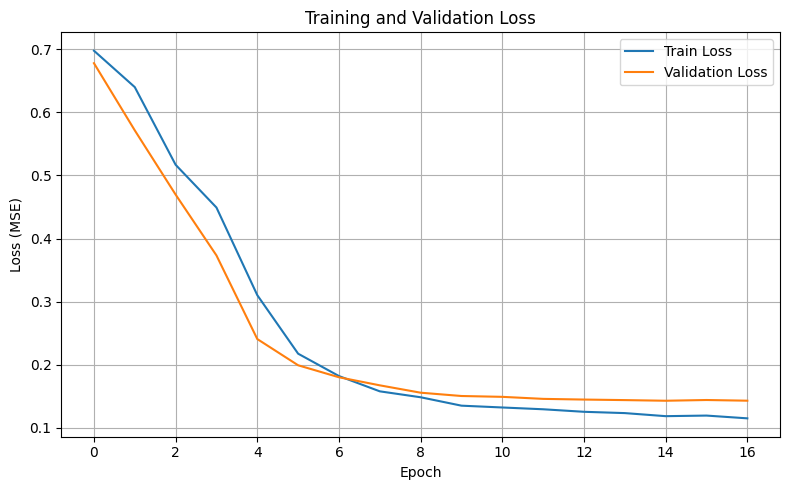

In [263]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
